In [1]:
%matplotlib inline

# import packages
import numpy as np
import time 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

from cycler import cycler


In [2]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(10,10,10), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (11,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 25
rcParams['font.weight'] = 300


> Check the training loss.

In [ ]:
temp = np.load("loss_results_3000.npz")
loss_array = temp["loss_array"]

plt.plot(loss_array)

> Restore trained normalizing flow.

In [ ]:
# import packages
import numpy as np
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#=======================================================================================================
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("flow_3000.pt", map_location=lambda storage, loc: storage); # load in cpu
flow.eval();


> Check training vs. validation to make sure the density estimator is well determined.

In [ ]:
# restore training data
temp = np.load("mock_all_spectra_no_noise_resample_prior_large_clean_2.npz")
spectra = temp["spectra"] # num_spectra, num_pixel
labels = temp["labels"] # num_labels, num_spectra
wavelength = temp["wavelength"]
print(spectra.shape)
print(labels.shape)

# convert into torch
y_tr = torch.from_numpy(spectra).type(torch.FloatTensor)

# sample log probablity
log_prob_x = flow.log_prob(y_tr).detach().numpy()


In [ ]:
ind_shuffle = np.load("ind_shuffle.npy")
plt.hist(log_prob_x[ind_shuffle][:12000], bins=100, normed=True);
plt.hist(log_prob_x[ind_shuffle][12000:], bins=100, normed=True, alpha=0.5);

> Check how the probability depends on Teff, perform a running mean and define outliers.

In [ ]:
# sort by teff
ind_sort = np.argsort(labels[0,:])
log_prob_x = log_prob_x[ind_sort]
spectra = spectra[ind_sort,:]
labels = labels[:,ind_sort]

In [ ]:
# plot results
teff = labels[0,:]
plt.scatter(teff, log_prob_x, s=3)

# running mean of log prob as a function of teff
low_1sigma = np.array([np.percentile(log_prob_x[i:i+2000], 35.2) for i in range(log_prob_x.size)])
median_log_prob = np.array([np.median(log_prob_x[i:i+2000]) for i in range(log_prob_x.size)])

plt.plot(teff, median_log_prob, color=cb2[3], lw=5)
plt.plot(teff, median_log_prob - 1*(median_log_prob-low_1sigma), color=cb2[3], lw=3, ls="--")

#--------------------------------------------------------------------------------------------------
# define outliers
sigma_cut = 8.
ind_outliers = log_prob_x < (median_log_prob - sigma_cut*(median_log_prob-low_1sigma))
ind_inside = log_prob_x >= (median_log_prob - sigma_cut*(median_log_prob-low_1sigma))

# plot results
plt.plot(teff, median_log_prob - sigma_cut*(median_log_prob-low_1sigma), color=cb2[3], lw=3, ls=":")
plt.scatter(teff[ind_outliers], log_prob_x[ind_outliers], color=cb2[1], s=10)

print("Remaining spectra:", np.sum(ind_inside), "/", spectra.shape[0])

In [ ]:
# save training set excluding the training set
np.savez("mock_all_spectra_no_noise_resample_prior_large_clean_2.npz",\
         wavelength = wavelength,\
         spectra = spectra[ind_inside,:],\
         labels = labels[:,ind_inside])


> Plot weird spectra.

In [ ]:
ind_sort = np.argsort(log_prob_x)
plt.plot(spectra[ind_sort[0],:])

## Check Payne interpolation.

> Check training loss.

In [ ]:
temp = np.load("training_loss.npz")
training_loss = temp["training_loss"]
validation_loss = temp["validation_loss"]

plt.ylim([0,20])
plt.plot(training_loss)
plt.plot(validation_loss)

> Check flux interpolation errors.

In [ ]:
# import The Payne github
from The_Payne import spectral_model

#------------------------------------------------------------------------------------------------
# restore array
tmp = np.load("NN_normalized_spectra.npz")
w_array_0 = tmp["w_array_0"]
w_array_1 = tmp["w_array_1"]
w_array_2 = tmp["w_array_2"]
b_array_0 = tmp["b_array_0"]
b_array_1 = tmp["b_array_1"]
b_array_2 = tmp["b_array_2"]
x_min = tmp["x_min"]
x_max = tmp["x_max"]

tmp.close()
NN_coeffs = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

#------------------------------------------------------------------------------------------------
# read spectra
temp = np.load("mock_all_spectra_no_noise_resample_prior_large.npz")
labels = temp["labels"].T
labels[:,0] = labels[:,0]/1000.
Y_u_all = temp["spectra"].T

# calculate spectra
predict_flux_array = []
for i in range(labels.shape[0]):
    if i % 1000 == 0:
        print(i)
    label_test = (labels[i,:]-x_min)/(x_max-x_min) - 0.5
    predict_flux_array.append(spectral_model.get_spectrum_from_neural_net(scaled_labels = label_test,\
                                                       NN_coeffs = NN_coeffs))

predict_flux_array = np.array(predict_flux_array).T
print(predict_flux_array.shape)

In [ ]:
# load training set
temp = np.load("mock_all_spectra_no_noise_resample_prior_large.npz")
labels_array = temp["labels"]
Y_u_all = temp["spectra"].T
wavelength_template = temp["wavelength"]

# restrict to only the validation set
temp = np.load("ind_shuffle_payne.npz")
ind_shuffle = temp["ind_shuffle"]

Y_u_all = Y_u_all[:,ind_shuffle][:,11000:]
predict_flux_array = predict_flux_array[:,ind_shuffle][:,11000:]
labels_array = labels_array[:,ind_shuffle][:,11000:]

# calculate flux deviation
flux_deviate = np.median(np.abs(Y_u_all - predict_flux_array),axis=1)
max_deviate = np.percentile(np.abs(Y_u_all - predict_flux_array),95,axis=1)
median_deviate = np.median(np.abs(Y_u_all - predict_flux_array),axis=0)


#===============================================================================================
# initiate the plot
fig = plt.figure(figsize=[22,15]);

# combine labels
ax = fig.add_subplot(111)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=0, bottom=0, left=0, right=0)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (1,0))

# axis labels
ax.set_xlabel(r"Wavelength [A]");
ax.set_ylabel(r"Median approximation error");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([15200,15300])
plt.ylim([10**-4,10**-2])

# plot in log scale
ax.set_yscale('log');

# plot results
plt.plot(wavelength_template, flux_deviate, color="black", lw=2)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (0,1))

# axis labels
ax.set_xlabel(r"(Wavelength) Median approximation error of The Payne");
ax.set_ylabel(r"# Cross validation models");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([-5,-2.])
plt.ylim([0,5.])

# set the range
plt.xticks([-5,-4,-3,-2],\
           ["$\mathregular{10^{-5}}$", "$\mathregular{10^{-4}}$", "$\mathregular{10^{-3}}$",\
            "$\mathregular{10^{-2}}$",])


#-------------------------------------------------------------------------------------------------
# plot result
choose = (labels_array[0,:] > 3000.)*(labels_array[0,:] < 4000.)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=100, color=cb2[0], lw=3, normed=True, range=[-5,-2])

choose = (labels_array[0,:] > 4000.)*(labels_array[0,:] < 5000.)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=100, color=cb2[3], lw=3, normed=True, range=[-5,-2])

choose = (labels_array[0,:] > 5000.)*(labels_array[0,:] < 10000.)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=100, color="black", lw=3, normed=True, range=[-5,-2])

# add legend
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[0], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 3000K - 4000K}$")
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[3], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 4000K - 5000K}$")
plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=3,\
          label=r"$\mathregular{T_{\rm eff} = 5000K - 10000K}$")

plt.legend(loc="upper right", fontsize=25, frameon=False,\
            borderpad=0.5, labelspacing=0.5)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (1,1))

# axis labels
ax.set_xlabel(r"(Spectrum) Median approximation error of The Payne");
ax.set_ylabel(r"Cumulative # wavelength pixels [%]");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([10**-5,10**-1.9])
plt.ylim([0.,1.0])

ax.set_xscale('log');

#-------------------------------------------------------------------------------------------------
# add end points
flux_deviate = np.concatenate([flux_deviate,[1.]])
max_deviate = np.concatenate([max_deviate,[1.]])

# plot result
plt.hist(flux_deviate,\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color="black")
plt.hist(max_deviate,\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color="black", ls=":")

# add legend
l3, = plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=2, ls="-", label="Median")
l4, = plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=2, ls=":", label=r"$\mathregular{2\sigma}$")

plt.legend(loc="lower right",\
           fontsize=25, frameon=False, borderpad=0.5, labelspacing=0.5)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (0,0))

# axis labels
ax.set_xlabel(r"Pixel-by-pixel approximation error of The Payne");
ax.set_ylabel(r"Cumulative # wavelength pixels [%]");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([10**-5,10**-1.9])
plt.ylim([0.,1.0])

ax.set_xscale('log');

#-------------------------------------------------------------------------------------------------
# plot result
choose = (labels_array[0,:] > 3000.)*(labels_array[0,:] < 4000.)
plt.hist(np.abs(Y_u_all[:,choose]-predict_flux_array[:,choose]).ravel(),\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color=cb2[0])

choose = (labels_array[0,:] > 4000.)*(labels_array[0,:] < 5000.)
plt.hist(np.abs(Y_u_all[:,choose]-predict_flux_array[:,choose]).ravel(),\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color=cb2[3])

choose = (labels_array[0,:] > 5000.)*(labels_array[0,:] < 10000.)
plt.hist(np.abs(Y_u_all[:,choose]-predict_flux_array[:,choose]).ravel(),\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color="black")

# add legend
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[0], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 3000K - 4000K}$")
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[3], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 4000K - 5000K}$")
plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=3,\
          label=r"$\mathregular{T_{\rm eff} = 5000K - 10000K}$")

plt.legend(loc="upper left", fontsize=25, frameon=False,\
            borderpad=0.5, labelspacing=0.5)
plt.tight_layout()

In [ ]:
plt.hist(np.log10(np.abs(predict_flux_array-Y_u_all)).ravel(), bins=100, range=[-6.5,-1], normed=True, alpha=0.5);
plt.xlabel("Log Flux Error")
plt.ylabel("# Pixels")

> Fitting mock spectra.

In [ ]:
from The_Payne import fitting
from The_Payne import spectral_model
from The_Payne import utils
import time
from multiprocessing import Pool
import numpy as np

# restore APOGEE properties
wavelength = utils.load_wavelength_array()
mask = utils.load_apogee_mask()

#------------------------------------------------------------------------------------------------
# restore array
tmp = np.load("NN_normalized_spectra.npz")
w_array_0 = tmp["w_array_0"]
w_array_1 = tmp["w_array_1"]
w_array_2 = tmp["w_array_2"]
b_array_0 = tmp["b_array_0"]
b_array_1 = tmp["b_array_1"]
b_array_2 = tmp["b_array_2"]
x_min = tmp["x_min"]
x_max = tmp["x_max"]

tmp.close()
NN_coeffs = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

#------------------------------------------------------------------------------------------------
# read spectra
temp = np.load("mock_all_spectra_no_noise_resample_prior_large.npz")
labels = temp["labels"].T
labels[:,0] = labels[:,0]/1000.
labels = (labels-x_min)/(x_max-x_min) - 0.5
labels[labels > 0.5] = 0.499
labels[labels < -0.5] = -0.499
Y_u_all = temp["spectra"]

# restrict to only the validation set
temp = np.load("ind_shuffle_payne.npz")
ind_shuffle = temp["ind_shuffle"]

labels = labels[ind_shuffle,:][11000:,:]
Y_u_all = Y_u_all[ind_shuffle,:][11000:,:]
print(labels.shape)

#------------------------------------------------------------------------------------------------
# print results
def fit_spectrum(i):
    spec_err = 1e-2*np.ones(len(wavelength))
    popt, pcov, model_spec = fitting.fit_normalized_spectrum_single_star_model(\
                                norm_spec = Y_u_all[i,:], spec_err = spec_err,\
                                NN_coeffs = NN_coeffs, wavelength = wavelength, mask=mask,\
                                p0 = np.concatenate([labels[i,:],[0]]))
    return popt

#------------------------------------------------------------------------------------------------
# fit in parallel
recovered_results = []
for i in range(labels.shape[0]):
    print(i)
    recovered_results.append(fit_spectrum(i))
recovered_results = np.array(recovered_results)

# num_CPU = 96
# pool = Pool(num_CPU)
# recovered_results = np.array(pool.map(fit_spectrum,range(Y_u_all.shape[0])))
# np.savez("recovered_results.npz", recovered_results = recovered_results)


In [10]:
# restore results
temp = np.load("recovered_results.npz")
recovered_results = temp["recovered_results"][:,:25].T
recovered_results[0,:] = recovered_results[0,:]*1000.

temp = np.load("mock_all_spectra_no_noise_resample_prior_large.npz")
labels_array = temp["labels"].T
temp = np.load("ind_shuffle_payne.npz")
ind_shuffle = temp["ind_shuffle"]
labels_array = labels_array[ind_shuffle,:][11000:,:]
labels_array = labels_array.T
teff = labels_array[0,:]

#--------------------------------------------------------------------------------------------------------
# x-axis array
x_array = np.arange(labels_array.shape[0])

# calculate deviation
hot_ind = (teff > 3000.)*(teff < 4000.)
deviat = (np.percentile(recovered_results[:,hot_ind]-labels_array[:,hot_ind], 68.3, axis=1)\
              - np.percentile(recovered_results[:,hot_ind]-labels_array[:,hot_ind], 31.7, axis=1))
deviat[0] = deviat[0]/1000.
deviat[-2] = deviat[-2]/100.
deviat_cold_ref = deviat[[0,1,2,24, 3,4,5,6,7, 8,9,10,11,12, 13,14,15,16,17, 18,19,20,21,22, 23]]

# calculate deviation
hot_ind = (teff > 4000.)*(teff < 5000.)
deviat = (np.percentile(recovered_results[:,hot_ind]-labels_array[:,hot_ind], 68.3, axis=1)\
              - np.percentile(recovered_results[:,hot_ind]-labels_array[:,hot_ind], 31.7, axis=1))
deviat[0] = deviat[0]/1000.
deviat[-2] = deviat[-2]/100.
deviat_hot_ref = deviat[[0,1,2,24, 3,4,5,6,7, 8,9,10,11,12, 13,14,15,16,17, 18,19,20,21,22, 23]]

#--------------------------------------------------------------------------------------------------------
np.savez("model_to_model_fit_deviation_large_network.npz",\
         deviat_hot_ref = deviat_hot_ref,\
         deviat_cold_ref = deviat_cold_ref)

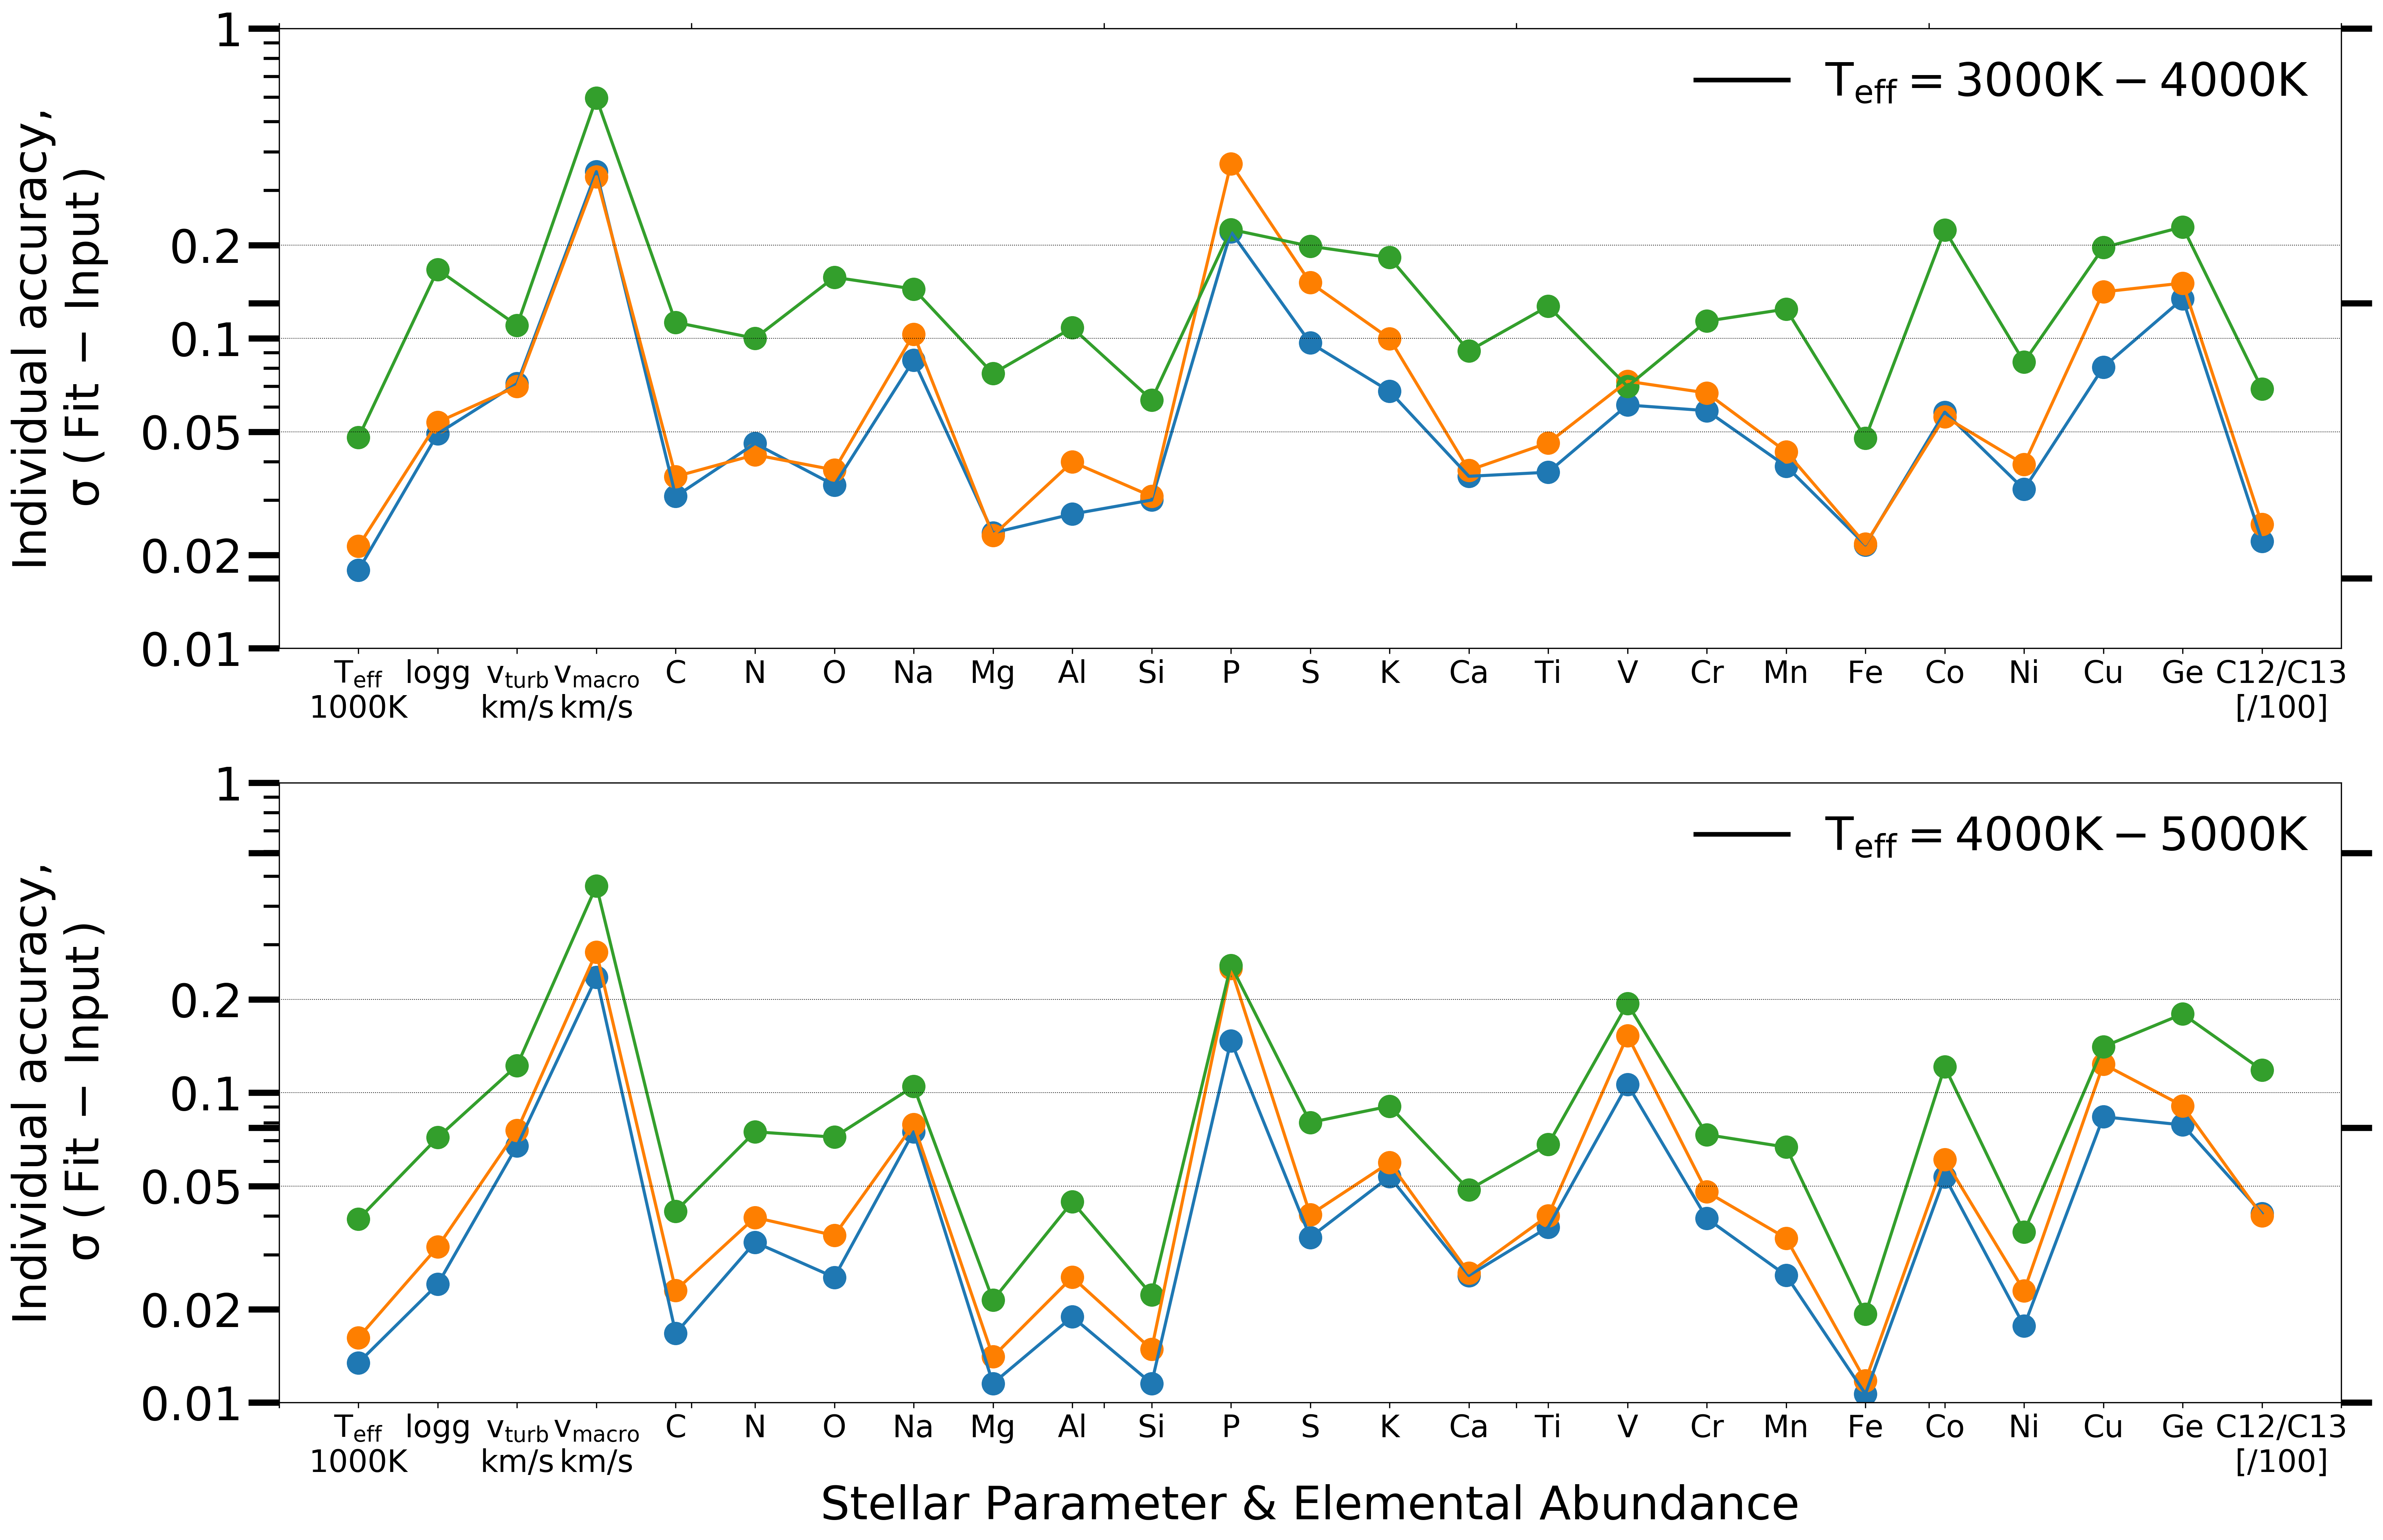

In [11]:
# restore results
temp = np.load("model_to_model_fit_deviation_ref.npz")
deviat_hot_ref = temp["deviat_hot_ref"]
deviat_cold_ref = temp["deviat_cold_ref"]

temp = np.load("model_to_model_fit_deviation_large_network.npz")
deviat_hot_large = temp["deviat_hot_ref"]
deviat_cold_large = temp["deviat_cold_ref"]

temp = np.load("model_to_model_fit_deviation_outlier_culled.npz")
deviat_hot_culled = temp["deviat_hot_ref"]
deviat_cold_culled = temp["deviat_cold_ref"]

x_array = np.arange(deviat_cold_culled.shape[0])


#====================================================================================================
# change plotting parameters
rcParams['ytick.major.size'] = 20
rcParams['ytick.major.width'] = 4
rcParams['ytick.minor.size'] = 10
rcParams['ytick.minor.width'] = 2

# initiate the plot
fig = plt.figure(figsize=[23,15]);

# combine labels
ax = fig.add_subplot(111)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')


#====================================================================================================
# initiate plot
ax = fig.add_subplot(211)

ax.set_yscale('log');
ax.set_ylabel("Individual accuracy,\n" + r"$\mathregular{\sigma \; ( \, Fit \, - \, Input \, )}$",\
              fontsize=30, labelpad=20);

# yrange
plt.xlim([-1,25.])
plt.ylim([10**-2.,10.**0.])
 
#------------------------------------------------------------------------------------------------------
# plot the deviation
l1, = plt.plot(x_array, deviat_cold_culled, lw=2, color=cb2[0]);
plt.scatter(x_array, deviat_cold_culled, s=200, color=cb2[0]);

l1, = plt.plot(x_array, deviat_cold_large, lw=2, color=cb2[1]);
plt.scatter(x_array, deviat_cold_large, s=200, color=cb2[1]);

l1, = plt.plot(x_array, deviat_cold_ref, lw=2, color=cb2[2]);
plt.scatter(x_array, deviat_cold_ref, s=200, color=cb2[2]);

#------------------------------------------------------------------------------------------------------
# add legend
plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 3000K - 4000K}$")
plt.legend(loc="upper right", fontsize=30, frameon=False,\
            borderpad=0.2, labelspacing=0.2, scatterpoints=1)
    
# change tick marks
plt.xticks(x_array,\
           ["$\mathregular{T_{eff}}$\n1000K", "logg",\
            "$\mathregular{v_{turb}}$\nkm/s", "$\mathregular{v_{macro}}$\nkm/s",\
            "C", "N", "O", "Na", "Mg",\
            "Al", "Si", "P", "S", "K",\
            "Ca", "Ti", "V", "Cr", "Mn",\
            "Fe", "Co", "Ni", "Cu", "Ge",\
            "    C12/C13\n    [/100]"], fontsize=20);

plt.yticks([0.01, 0.02, 0.05, 0.1, 0.2, 1.], ["0.01", "0.02", "0.05", "0.1", "0.2", "1"], fontsize=30)

# draw delimitation line
plt.plot([-10,30], [0.05,0.05], color="black", lw=0.5, ls=":")
plt.plot([-10,30], [0.1,0.1], color="black", lw=0.5, ls=":")
plt.plot([-10,30], [0.2,0.2], color="black", lw=0.5, ls=":")


#====================================================================================================
# initiate plot
ax = fig.add_subplot(212)

# plot in log scale
ax.set_yscale('log');

# axis labels
ax.set_xlabel("Stellar Parameter & Elemental Abundance", fontsize=30);
ax.set_ylabel("Individual accuracy,\n" + r"$\mathregular{\sigma \; ( \, Fit \, - \, Input \, )}$",\
              fontsize=30, labelpad=20);

# yrange
plt.xlim([-1,25.])
plt.ylim([10**-2.,10.**0.])
 
#------------------------------------------------------------------------------------------------------
# plot the deviation
l1, = plt.plot(x_array, deviat_hot_culled, lw=2, color=cb2[0]);
plt.scatter(x_array, deviat_hot_culled, s=200, color=cb2[0]);

l1, = plt.plot(x_array, deviat_hot_large, lw=2, color=cb2[1]);
plt.scatter(x_array, deviat_hot_large, s=200, color=cb2[1]);

l1, = plt.plot(x_array, deviat_hot_ref, lw=2, color=cb2[2]);
plt.scatter(x_array, deviat_hot_ref, s=200, color=cb2[2]);

#------------------------------------------------------------------------------------------------------
# add legend
plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 4000K - 5000K}$")
plt.legend(loc="upper right", fontsize=30, frameon=False,\
            borderpad=0.2, labelspacing=0.2, scatterpoints=1)
    
# change tick marks
plt.xticks(x_array,\
           ["$\mathregular{T_{eff}}$\n1000K", "logg",\
            "$\mathregular{v_{turb}}$\nkm/s", "$\mathregular{v_{macro}}$\nkm/s",\
            "C", "N", "O", "Na", "Mg",\
            "Al", "Si", "P", "S", "K",\
            "Ca", "Ti", "V", "Cr", "Mn",\
            "Fe", "Co", "Ni", "Cu", "Ge",\
            "    C12/C13\n    [/100]"], fontsize=20);

plt.yticks([0.01, 0.02, 0.05, 0.1, 0.2, 1.], ["0.01", "0.02", "0.05", "0.1", "0.2", "1"], fontsize=30)

# draw delimitation line
plt.plot([-10,30], [0.05,0.05], color="black", lw=0.5, ls=":")
plt.plot([-10,30], [0.1,0.1], color="black", lw=0.5, ls=":")
plt.plot([-10,30], [0.2,0.2], color="black", lw=0.5, ls=":")


#====================================================================================================
# save figure
plt.tight_layout()
#plt.savefig("Fig5.pdf")
